# MHKiT Tidal 

This jupyter notebook will familiarize the user with the mhkit tidal module by stepping through the calculation of the calculation of the velocity duration curve. First, let us load the Tidal module. Below we import 3 standard python packages. Pandas, numpy, and matplotlib. With respect to MHKit, all of the tidal functions are imported with respect to each of the functional groupings. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mhkit.tidal import device, resource, graphics, io

## Importing Data from NOAA-Currents
   
THis example will pull 1 year of data frooooom the NOAA-Currents site available sites can be viewed on the map  Check the map for available currents stations https://tidesandcurrents.noaa.gov/map/. We will start by requesting 1 year of 6 minute averaged data from the Southampton Shoal Channel LB 6 (Station Number: s08010) in San Francisco Bay. The function request_noaa_data in the MHKit tidal IO module returns a Pandas DataFrame. To use the request_noaa_data function we will need a station number, parameter type, a start date and an end date. The station ID can be found on the NOAA tides and currents website linked above. The IEC standard recommends 1 year of 10 minute direction and velocity data. The request_noaa_data function allows users to easily pull any timeframe of data although NOAA limits any one pull to 30 days.

In [2]:
# Create a file name to save the requested data 
currents_file = 'data/s08010.json' #South Hampton Shoal LB 6 

# If the file exists load the data
if os.path.isfile(currents_file):
    data, metadata = io.read_noaa_json(currents_file)
# If the file is not found request the data from NOAA and save it (write_json)
else:
    # Request data from NOAA, 
    data,metadata = io.request_noaa_data(station='s08010', parameter='currents',
                               start_date='20161101', end_date='20180401',
                               proxy=None, write_json=currents_file)
# Convert to discharge data from cm/s to m/s
data.s = data.s / 100

The request_noaa_data has returned a pandas DataFrame of time series data between November of 2016 and March of 2018. The time series data points are 6 minute averaged direction [degrees] and speed [cm/s] data indexed by time. The DataFrame key names returned by NOAA are 'd' for direction and 's' for speed. The speed returned from NOAA is in cm/s so we will convert this to m/s. An initial data check may look at the timeseries data to identify how any missing data. To do this we will convert the speed data to velocity using the directional data. To choose a direction to calculate the velocity on we will use the `resource.principal_flow_direction` function. This function returns 2 directions in degrees corresponding to the flood and ebb directions of the tidal site. From these two direction we can choose either as our principal flow direction. The `graphics.plot_current_timeseries` function then calculates velocity to the chosen direction for all speeds in the passed timeseries.

In [3]:
# We need to specify a histogram bin width for the directions to 
#    calculate the principal flow directions 
width_direction = 1   #[degrees]

# Two principal directions are caluculated nased on the highest frequency direction
#    one direction is flood, and the other is tide. These directions are close to 
#    180 degrees apart but not required to be. 
direction1, direction2 = resource.principal_flow_directions(data.d, width_direction)

# Set flood and ebb directions based on site knowledge
flood= direction1 # Flow into 
ebb  = direction2 # Flow out 

Using either of the calculated directions we can plot the time series of returned data using the `graphics.plot_current_timeseries' function.

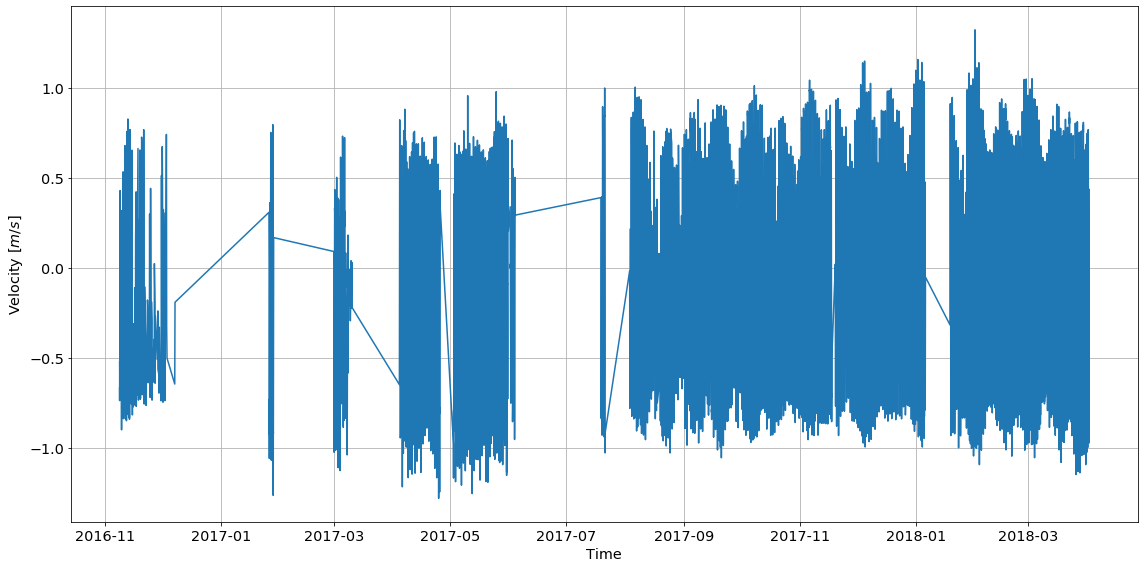

In [4]:
graphics.plot_current_timeseries(data.d, data.s, flood)

The plot above shows that the NOAA site request did not return data for most of early and mid 2017. The IEC standard reccomends a minimum of 1 year of 10 minute averaged data (See IEC 201 for full description). For the purposes of demonstration this dataset is suffcient. To look at a speficic month we can slice the dataset before passing to the plotting function.

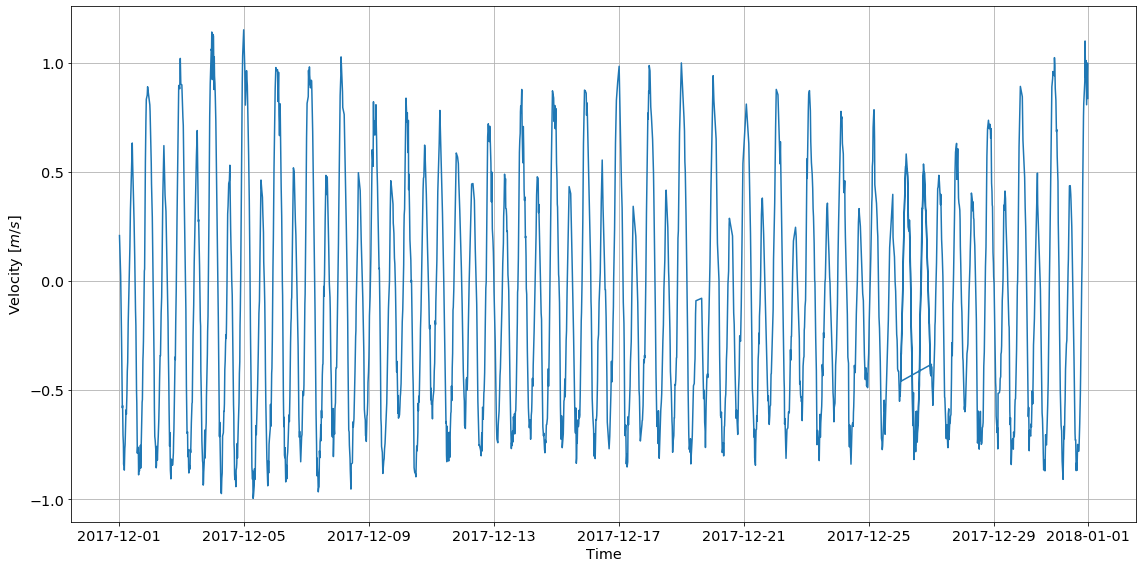

In [5]:
# Slice December of 2017 out of the full dataset
data2 = data.loc['2017-12-01':'2017-12-31']
# Then plot December of 2017 as current timeseries
graphics.plot_current_timeseries(data2.d, data2.s, flood)

### Plot the data as a joint probability distribution

The data points may also be viewed as a joint porbabilty distribution of direction and velocity on a polar plot. This plot will help visually show the flood and ebb directions and the frequency of particular directions/ velocities. 

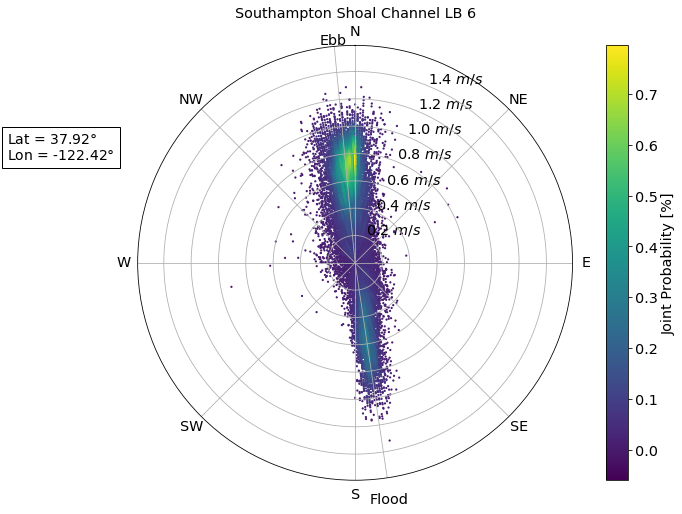

In [6]:
# Set the joint probabilty bin widths
width_direction = 1   #[degrees]
width_velocity  = 0.1 #[m/s]

# Plot the joint probability distribution
graphics.plot_joint_probability_distribution(data['d'], data['s'],
                   width_direction, width_velocity, metadata=metadata,
                                            flood=flood, ebb=ebb)

### Plot the data as a rose plot

One additional polar plot of interest maybe the rose plot. This plot shows the same information as the joint probability distribution but the probability is now the r-axis, and the velocity is the contour value. 

<BarContainer object of 36 artists>

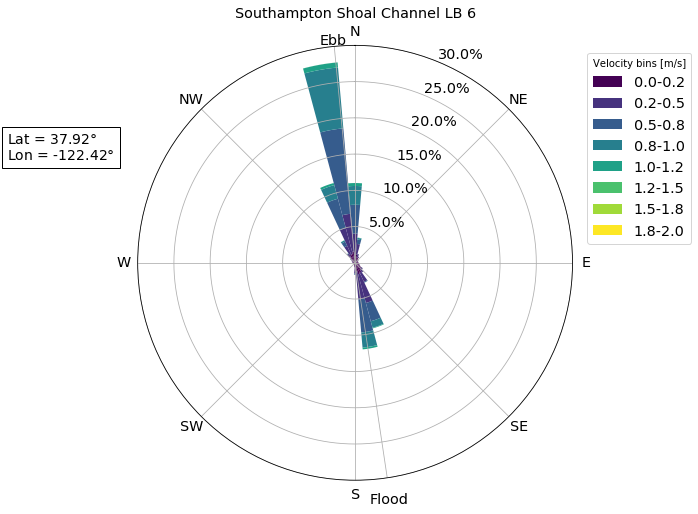

In [7]:
# Rose plot is more readable using larger bins sizes the jpd plot
width_direction = 10   #[degrees]
width_velocity  = 0.25 #[m/s]

# Plot the joint probability distribution
graphics.plot_rose(data['d'], data['s'],
                   width_direction, width_velocity, metadata=metadata,
                  flood=flood, ebb=ebb)

## Velocity Duration Curve

The velocity duration curve shows the probability of achiving a particular velocity value. This may be plotted by calculating the exceedance probability of the velocity (rank order velocity values).

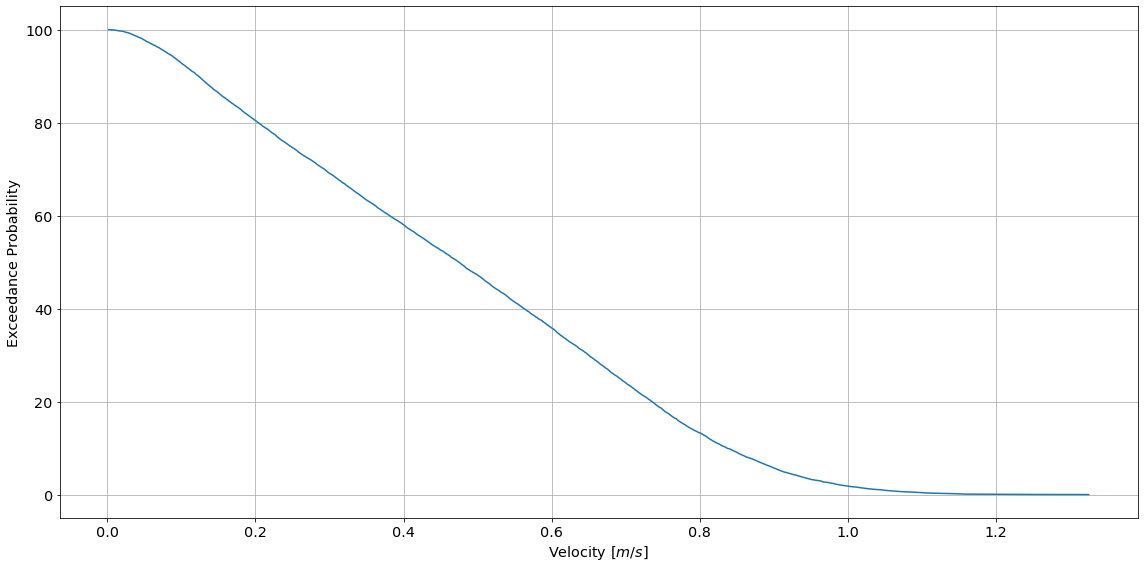

In [8]:
# Calculate Exceedance probability of data
data['F'] = resource.exceedance_probability(data.s)

# Plot VDC
graphics.plot_velocity_duration_curve(data.s, data.F )